In [ ]:
!pip install numpy==1.17.4
!pip install keras-retinanet
!pip install pycocotools


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached numpy-1.17.4.zip (6.4 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [2937 lines of output]
      Running from numpy source directory.
      blas_opt_info:
      blas_mkl_info:
      customize UnixCCompiler
        FOUND:
          libraries = ['mkl_rt', 'pthread']
          library_dirs = ['/opt/conda/lib']
          define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
          include_dirs = ['/usr/local/include', '/usr/include', '/opt/conda/include']
      
        FOUND:
          libraries = ['mkl_rt', 'pthread']
          library_dirs = ['/opt/conda/lib']
          define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
          include_dirs = ['/usr/local/include', '/usr/include', '/opt/conda/include']
      
      /bin/sh: 1: svnversion: not found
      non-existing path in 'numpy/distutils': 'site.cfg'
      lapack_opt_info:
  

In [ ]:
pip install git+https://github.com/fizyr/keras-retinanet.git --upgrade


In [ ]:
print("Keys in train_annotations:", train_annotations.keys())
print("First annotation:", train_annotations['annotations'][0])
print("First image:", train_annotations['images'][0])


Keys in train_annotations: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
First annotation: {'id': 0, 'image_id': 0, 'category_id': 2, 'bbox': [140, 262, 21, 25.5], 'area': 535.5, 'segmentation': [], 'iscrowd': 0}
First image: {'id': 0, 'license': 1, 'file_name': '1478897026627294725_jpg.rf.6828a4e821cbab4c2c277d74df291f00.jpg', 'height': 512, 'width': 512, 'date_captured': '2021-06-09T12:24:25+00:00'}


# **YOLOv8**

In [ ]:
pip install ultralytics


In [ ]:
pip install opencv-python


In [ ]:
pip install grad-cam


In [ ]:

import os
import shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image


from ultralytics import YOLO  # For YOLOv8
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.image import show_cam_on_image


In [ ]:
import os

def explore_dataset(dataset_path):
    for root, dirs, files in os.walk(dataset_path):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)

#
dataset_path = "/kaggle/input/retinanet/Self Driving Car/export"
explore_dataset(dataset_path)


In [ ]:
import os


dataset_path = "/kaggle/input/retinanet/Self Driving Car/export"


print("Total Images:", len(os.listdir(dataset_path)))
print("Sample Files:", os.listdir(dataset_path)[:5])


Total Images: 29801
Sample Files: ['1478900814278399033_jpg.rf.KeAPtrlh0ZRRk6ZiKs9Q.jpg', '1478899822519346516_jpg.rf.0CaEssvbf3X8EhzEcKYy.jpg', '1478901375856393827_jpg.rf.1S961wwKb7FA7YyHUFQN.jpg', '1478896688423612224_jpg.rf.c9b536060ee622e25fabe8ac5122228b.jpg', '1478899096411167283_jpg.rf.Pq6cGOUmbePUxNfBPK8l.jpg']


In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define dataset path and output paths
dataset_path = "/kaggle/input/retinanet/Self Driving Car/export"
output_dir = "/kaggle/working/export"

train_dir = os.path.join(output_dir, "train/images")
val_dir = os.path.join(output_dir, "val/images")

# Create directories in a writable location
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all image files in the dataset path
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]

# Split into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Copy files to the respective directories
for file in train_files:
    shutil.copy(os.path.join(dataset_path, file), train_dir)

for file in val_files:
    shutil.copy(os.path.join(dataset_path, file), val_dir)

print("Training Set:", len(os.listdir(train_dir)))
print("Validation Set:", len(os.listdir(val_dir)))


Training Set: 23840
Validation Set: 5960


In [ ]:
import json

annotations_file = "/kaggle/input/retinanet/Self Driving Car/export/_annotations.coco.json"  # Update this with the correct path

train_labels_dir = os.path.join(output_dir, "train/labels")
val_labels_dir = os.path.join(output_dir, "val/labels")
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)


with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

def coco_to_yolo(bbox, img_width, img_height):
    x_min, y_min, width, height = bbox
    x_center = (x_min + width / 2) / img_width
    y_center = (y_min + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

image_id_to_annotations = {}
for annotation in coco_data["annotations"]:
    image_id = annotation["image_id"]
    if image_id not in image_id_to_annotations:
        image_id_to_annotations[image_id] = []
    image_id_to_annotations[image_id].append(annotation)

def create_yolo_labels(image_dir, labels_dir, split_files, coco_data):
    for img_info in coco_data["images"]:
        img_name = img_info["file_name"]
        if img_name not in split_files:
            continue


        img_id = img_info["id"]
        img_width = img_info["width"]
        img_height = img_info["height"]


        annotations = image_id_to_annotations.get(img_id, [])


        label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            for ann in annotations:
                category_id = ann["category_id"]
                bbox = ann["bbox"]
                yolo_bbox = coco_to_yolo(bbox, img_width, img_height)
                f.write(f"{category_id - 1} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")


create_yolo_labels(train_dir, train_labels_dir, train_files, coco_data)
create_yolo_labels(val_dir, val_labels_dir, val_files, coco_data)

print("YOLO Labels Created for Training and Validation.")


YOLO Labels Created for Training and Validation.


In [ ]:

class_names = [category["name"] for category in coco_data["categories"]]


yolo_config_path = os.path.join(output_dir, "yolo_config.yaml")
yolo_config_content = f"""
path:/kaggle/working/output_dataset  # Base dataset path
train:/kaggle/working/output_dataset/train/images # Training images directory
val:/kaggle/working/output_dataset/val/images # Validation images directory

nc: 12  # Number of classes
names: ['obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']  # Class names
"""


with open(yolo_config_path, 'w') as f:
    f.write(yolo_config_content)

print("YOLO Config File Created:", yolo_config_path)


YOLO Config File Created: /kaggle/working/export/yolo_config.yaml


In [ ]:

print("Sample Train Labels:", os.listdir(train_labels_dir)[:5])
print("Sample Validation Labels:", os.listdir(val_labels_dir)[:5])


Sample Train Labels: ['1478898534833039918_jpg.rf.16f9fa10404ca7953e69ef577a6877b7.txt', '1478896692423464692_jpg.rf.HSJamM3RAJeOLJhqyNVb.txt', '1478732873218151467_jpg.rf.fnz8HTVj3XFk2Je5jKtG.txt', '1478732019300713970_jpg.rf.aa7b3ec20e2597a5d44b2d4c23285d01.txt', '1478897505367806377_jpg.rf.c8313e2a68b584f033e8b73971f256f3.txt']
Sample Validation Labels: ['1478900639464018209_jpg.rf.774707991a9bfc1aee88c8ade2d25294.txt', '1478732112778617977_jpg.rf.EQnVwzO4Lvev1HGpzN2g.txt', '1478897396822646254_jpg.rf.nbPab5cJyVy4ajI6fTmW.txt', '1478897403678953286_jpg.rf.VIDVet8F3ZND2sIrKqhH.txt', '1478021030716739507_jpg.rf.3d338b2e08bdfb1e19e3e53dcfc927af.txt']


In [ ]:
import yaml

yolo_config = {
    'path': '/kaggle/working/export',
    'train': '/kaggle/working/export/train/images',
    'val': '/kaggle/working/export/val/images',
    'nc': 12,
    'names': ['obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green',
              'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft',
              'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']
}

with open('/kaggle/working/export/yolo_config.yaml', 'w') as f:
    yaml.dump(yolo_config, f, default_flow_style=False)

print("Corrected YOLO Config File Written!")


Corrected YOLO Config File Written!


In [ ]:
!pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:

from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(
    data="/kaggle/working/export/yolo_config.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    project="/kaggle/working",
    name="yolo_training",
    workers=2
)


Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/export/yolo_config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=/kaggle/working, name=yolo_training2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /kaggle/working/export/train/labels.cache... 23840 images, 2799 backgrounds, 0 corrupt: 100%|██████████| 23840/23840 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/export/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478732687982611234_jpg.rf.933608d03fb6966a684292a007ee34ff.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478897998391212266_jpg.rf.c01b68ef6c2581430db942682f763689.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/export/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed
train: WARNING

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/export/val/labels.cache... 5960 images, 701 backgrounds, 0 corrupt: 100%|██████████| 5960/5960 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/export/val/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed


Plotting labels to /kaggle/working/yolo_training2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/yolo_training2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.42G      1.589      1.639      1.167        178        640: 100%|██████████| 1490/1490 [04:46<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:33<00:00,  5.62it/s]


                   all       5960      38804      0.564      0.314      0.327      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.56G      1.525      1.119      1.152        172        640: 100%|██████████| 1490/1490 [04:38<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:33<00:00,  5.66it/s]


                   all       5960      38804      0.611      0.362      0.396      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.42G      1.511      1.039      1.147        160        640: 100%|██████████| 1490/1490 [04:34<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.67it/s]


                   all       5960      38804      0.713      0.402      0.442      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.39G      1.493     0.9907      1.143        108        640: 100%|██████████| 1490/1490 [04:32<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.68it/s]


                   all       5960      38804      0.764      0.398      0.469      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.4G      1.471     0.9556      1.133        141        640: 100%|██████████| 1490/1490 [04:33<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.70it/s]


                   all       5960      38804      0.711      0.463      0.508      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.41G      1.451     0.9283      1.125        141        640: 100%|██████████| 1490/1490 [04:33<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:33<00:00,  5.61it/s]


                   all       5960      38804      0.745      0.459      0.525      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.39G      1.442     0.9119       1.12        160        640: 100%|██████████| 1490/1490 [04:32<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.70it/s]


                   all       5960      38804      0.754      0.474      0.543      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.43G      1.414     0.8814      1.108         75        640: 100%|██████████| 1490/1490 [04:32<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.71it/s]


                   all       5960      38804      0.769      0.477      0.562      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.57G      1.407     0.8669      1.104        108        640: 100%|██████████| 1490/1490 [04:32<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.68it/s]


                   all       5960      38804      0.766       0.51      0.575      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.54G      1.395     0.8522      1.098        162        640: 100%|██████████| 1490/1490 [04:33<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.68it/s]


                   all       5960      38804      0.779      0.506      0.589      0.313
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.47G      1.405     0.8191      1.113         94        640: 100%|██████████| 1490/1490 [04:30<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:33<00:00,  5.66it/s]


                   all       5960      38804      0.794      0.537      0.605      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.38G      1.386     0.7989      1.104         90        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.75it/s]


                   all       5960      38804      0.794       0.56      0.635      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.39G      1.373     0.7801      1.098         90        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.71it/s]


                   all       5960      38804      0.801      0.564      0.641      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.38G      1.358     0.7652      1.092         79        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.71it/s]


                   all       5960      38804      0.812      0.577      0.651      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.38G      1.343     0.7489      1.083         94        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.71it/s]


                   all       5960      38804      0.835      0.588       0.66      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.38G      1.334     0.7393       1.08         98        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.71it/s]


                   all       5960      38804      0.819      0.591      0.668      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.46G      1.319     0.7251      1.073         97        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.68it/s]


                   all       5960      38804      0.834      0.594       0.67      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.38G      1.308     0.7133      1.069        114        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:33<00:00,  5.66it/s]


                   all       5960      38804      0.825      0.602      0.679      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.38G      1.298     0.7028      1.064        107        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.69it/s]


                   all       5960      38804      0.836      0.599      0.676       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.38G      1.288     0.6933      1.061        107        640: 100%|██████████| 1490/1490 [04:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:32<00:00,  5.69it/s]


                   all       5960      38804      0.842      0.598      0.688      0.385

20 epochs completed in 1.704 hours.
Optimizer stripped from /kaggle/working/yolo_training2/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/yolo_training2/weights/best.pt, 6.3MB

Validating /kaggle/working/yolo_training2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:38<00:00,  4.87it/s]


                   all       5960      38804      0.842      0.599      0.688      0.385
             obstacles        480        712      0.698      0.619      0.673      0.365
                 biker       5153      25577      0.866      0.795      0.853      0.567
                   car       1418       4340      0.732      0.537      0.627      0.306
            pedestrian        636       1007      0.836      0.795      0.836      0.488
          trafficLight        745       2104      0.826      0.624      0.725      0.321
    trafficLight-Green         81        125      0.863      0.554      0.655      0.364
trafficLight-GreenLeft       1031       2673      0.901      0.731      0.826      0.471
      trafficLight-Red        506        666      0.906      0.697      0.799      0.462
  trafficLight-RedLeft         41         92      0.797      0.468      0.617      0.248
   trafficLight-Yellow          1          1          1          0      0.124     0.0622
trafficLight-YellowLe

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4f395eb3a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [ ]:

results = model.val(
    data="/kaggle/working/export/yolo_config.yaml",
    batch=16,
    imgsz=640,
    device=0
)
print(results)

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/export/val/labels.cache... 5960 images, 701 backgrounds, 0 corrupt: 100%|██████████| 5960/5960 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/export/val/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 373/373 [00:42<00:00,  8.88it/s]


                   all       5960      38804      0.839        0.6      0.688      0.386
             obstacles        480        712      0.692      0.617      0.673      0.366
                 biker       5153      25577      0.863      0.797      0.853      0.568
                   car       1418       4340      0.723      0.538      0.626      0.305
            pedestrian        636       1007      0.834      0.796      0.836      0.488
          trafficLight        745       2104      0.821      0.625      0.722      0.321
    trafficLight-Green         81        125      0.863      0.557      0.656      0.364
trafficLight-GreenLeft       1031       2673        0.9      0.733      0.824      0.471
      trafficLight-Red        506        666      0.905        0.7        0.8      0.467
  trafficLight-RedLeft         41         92      0.797       0.47       0.62      0.254
   trafficLight-Yellow          1          1          1          0      0.124     0.0622
trafficLight-YellowLe

In [ ]:

print(results.box)

results.plot()


ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.67251,     0.65137,     0.62181,     0.55361,      0.4547,      0.3395,     0.22505,     0.11256,    0.023925,  0.00020974],
       [    0.85302,     0.84232,     0.82462,      0.7914,     0.73207,     0.63426,     0.49668,     0.32332,     0.15229,    0.025883],
       [    0.62594,     0.59088,     0.54268,     0.46529,     0.36723,     0.25549,      0.1328,    0.055593,    0.012317,   0.0011191],
       [    0.83604,     0.81037,     0.77502,     0.71013,     0.61606,      0.4952,     0.35579,     0.19865,    0.078402,   0.0048239],
       [    0.72166,      0.6773,     0.60314,     0.49724,     0.36277,     0.20411,    0.095408,    0.029831,   0.0092786,   0.0052101],
       [    0.65629,     0.62092,     0.53381,     0.50421,      0.4256,     0.36186,     0.26989,     0.18121,     0.08468,           0],
       [    0.82439,     0.80094,     0.76606,     0.70513,     0.61878,     0.48242,     0.32332,  

TypeError: 'bool' object is not callable

In [ ]:
print(type(results))


<class 'ultralytics.utils.metrics.DetMetrics'>


In [ ]:

print("IoU Results:")
print(results.box)


IoU Results:
ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.67251,     0.65137,     0.62181,     0.55361,      0.4547,      0.3395,     0.22505,     0.11256,    0.023925,  0.00020974],
       [    0.85302,     0.84232,     0.82462,      0.7914,     0.73207,     0.63426,     0.49668,     0.32332,     0.15229,    0.025883],
       [    0.62594,     0.59088,     0.54268,     0.46529,     0.36723,     0.25549,      0.1328,    0.055593,    0.012317,   0.0011191],
       [    0.83604,     0.81037,     0.77502,     0.71013,     0.61606,      0.4952,     0.35579,     0.19865,    0.078402,   0.0048239],
       [    0.72166,      0.6773,     0.60314,     0.49724,     0.36277,     0.20411,    0.095408,    0.029831,   0.0092786,   0.0052101],
       [    0.65629,     0.62092,     0.53381,     0.50421,      0.4256,     0.36186,     0.26989,     0.18121,     0.08468,           0],
       [    0.82439,     0.80094,     0.76606,     0.70513,     0.61878,     0.48242,  

In [ ]:

map50 = results.box.map50
map75 = results.box.map75
map50_95 = results.box.map

print(f"mAP@50: {map50}")
print(f"mAP@75: {map75}")
print(f"mAP@50-95: {map50_95}")


mAP@50: 0.6877565920091109
mAP@75: 0.37236504887660327
mAP@50-95: 0.3862257554826752


In [ ]:

num_classes = results.box.nc
for i in range(num_classes):
    precision, recall, ap50, ap = results.box.class_result(i)
    print(f"Class {i} - Precision: {precision}, Recall: {recall}, AP@50: {ap50}, AP@50-95: {ap}")


Class 0 - Precision: 0.6919350135694992, Recall: 0.6165730337078652, AP@50: 0.6725140981317063, AP@50-95: 0.3655241243328443
Class 1 - Precision: 0.8633361424035292, Recall: 0.7968487312820112, AP@50: 0.8530156772878252, AP@50-95: 0.5675861193240868
Class 2 - Precision: 0.7225895301057401, Recall: 0.5377880184331797, AP@50: 0.6259383482071473, AP@50-95: 0.3049333401343847
Class 3 - Precision: 0.8340063635135714, Recall: 0.7964250248262165, AP@50: 0.8360379181522819, AP@50-95: 0.4880466418007486
Class 4 - Precision: 0.8210165533225414, Recall: 0.6254752851711026, AP@50: 0.7216640283838137, AP@50-95: 0.32059444951698896
Class 5 - Precision: 0.8634903819648996, Recall: 0.5566674000963996, AP@50: 0.6562863570505535, AP@50-95: 0.363847693633935
Class 6 - Precision: 0.9002419305880186, Recall: 0.7326085726474065, AP@50: 0.8243875331990416, AP@50-95: 0.4713007579628079
Class 7 - Precision: 0.905316521945537, Recall: 0.6996996996996997, AP@50: 0.799623064962451, AP@50-95: 0.46677801597974344
C

IndexError: index 11 is out of bounds for axis 0 with size 11

In [ ]:

all_ap = results.box.all_ap

print("AP scores for all IoU thresholds (0.50 to 0.95):")
for i, class_ap in enumerate(all_ap):
    print(f"Class {i}: {class_ap}")


AP scores for all IoU thresholds (0.50 to 0.95):
Class 0: [    0.67251     0.65137     0.62181     0.55361      0.4547      0.3395     0.22505     0.11256    0.023925  0.00020974]
Class 1: [    0.85302     0.84232     0.82462      0.7914     0.73207     0.63426     0.49668     0.32332     0.15229    0.025883]
Class 2: [    0.62594     0.59088     0.54268     0.46529     0.36723     0.25549      0.1328    0.055593    0.012317   0.0011191]
Class 3: [    0.83604     0.81037     0.77502     0.71013     0.61606      0.4952     0.35579     0.19865    0.078402   0.0048239]
Class 4: [    0.72166      0.6773     0.60314     0.49724     0.36277     0.20411    0.095408    0.029831   0.0092786   0.0052101]
Class 5: [    0.65629     0.62092     0.53381     0.50421      0.4256     0.36186     0.26989     0.18121     0.08468           0]
Class 6: [    0.82439     0.80094     0.76606     0.70513     0.61878     0.48242     0.32332     0.14757      0.0414   0.0030251]
Class 7: [    0.79962     0.77219 

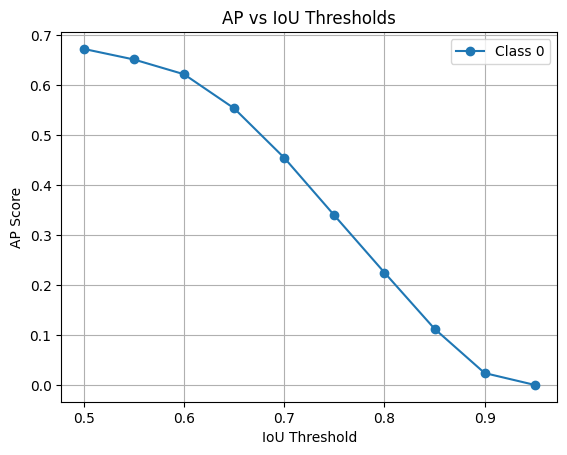

In [ ]:
import matplotlib.pyplot as plt


class_index = 0
iou_thresholds = [0.5 + i * 0.05 for i in range(10)]
ap_scores = results.box.all_ap[class_index]

plt.plot(iou_thresholds, ap_scores, marker='o', label=f"Class {class_index}")
plt.xlabel("IoU Threshold")
plt.ylabel("AP Score")
plt.title("AP vs IoU Thresholds")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

print(dir(results))


['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__cuda_array_interface__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rfloordiv__', '__rlshift__', '__rmat

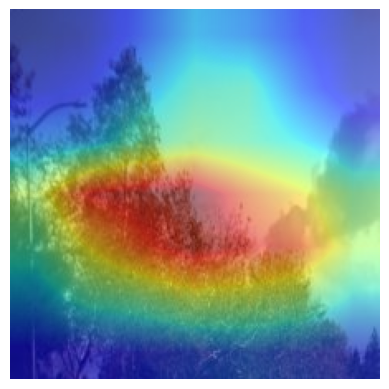

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def yolov8_reshape_transform(x):
    """
    Reshape transform to extract the feature maps for Grad-CAM.
    YOLOv8's feature maps need to be transformed to a usable shape.
    """
    return x if isinstance(x, torch.Tensor) else x[0]


model_path = "/kaggle/working/yolov8n.pt"
loaded_model = torch.load(model_path)
model = loaded_model['model'].float().eval()


target_layers = [model.model[21]]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cam = EigenCAM(model.to(device), target_layers, reshape_transform=yolov8_reshape_transform)


image_path = "/kaggle/working/export/val/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg"
image = Image.open(image_path).convert("RGB")
image = image.resize((640, 640))
image_np = np.array(image) / 255.0
input_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(device).float()


with torch.no_grad():
    outputs = model(input_tensor)


feature_maps = outputs[0] if isinstance(outputs, tuple) else outputs


grayscale_cam = cam(input_tensor)[0]
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)


plt.imshow(cam_image)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


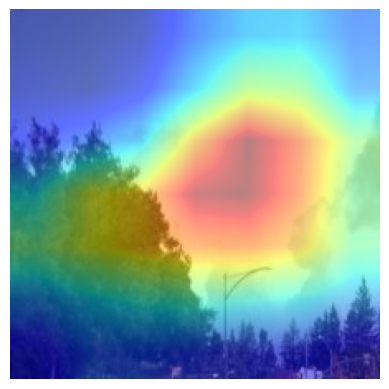

In [ ]:




def yolov8_reshape_transform(x):
    """
    Reshape transform to extract the feature maps for Grad-CAM.
    YOLOv8's feature maps need to be transformed to a usable shape.
    """
    return x if isinstance(x, torch.Tensor) else x[0]


model_path = "/kaggle/working/yolov8n.pt"
loaded_model = torch.load(model_path)
model = loaded_model['model'].float().eval()

target_layers = [model.model[21]]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cam = EigenCAM(model.to(device), target_layers, reshape_transform=yolov8_reshape_transform)


image_path = "/kaggle/working/export/val/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg"
image = Image.open(image_path).convert("RGB")
image = image.resize((640, 640))
image_np = np.array(image) / 255.0
input_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(device).float()


with torch.no_grad():
    outputs = model(input_tensor)


feature_maps = outputs[0] if isinstance(outputs, tuple) else outputs


grayscale_cam = cam(input_tensor)[0]
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)


plt.imshow(cam_image)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()


In [ ]:
print(model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [ ]:
!pip install grad-cam


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=5ef0383d3c16885d7a14ce55780d7eada1f98f8e0da60ed219d2d34c5e3fcbc7
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import pytorch_grad_cam


In [ ]:


def yolov8_reshape_transform(x):
    """
    Reshape transform to extract the feature maps for Grad-CAM.
    YOLOv8's feature maps need to be transformed to a usable shape.
    """
    return x if isinstance(x, torch.Tensor) else x[0]

model_path = "/kaggle/working/yolov8n.pt"
loaded_model = torch.load(model_path)
model = loaded_model['model'].float().eval()

target_layers = [model.model[21]]  # Use a deep convolutional layer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cam = EigenCAM(model.to(device), target_layers, reshape_transform=yolov8_reshape_transform)

# Load and preprocess an image
image_path = "/kaggle/working/export/val/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg"  # Update with your image path
image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
image = image.resize((640, 640))  # Resize to model input dimensions
image_np = np.array(image) / 255.0  # Normalize image to [0, 1]
input_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(device).float()  # Convert to (B, C, H, W)

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor)  # YOLOv8 forward pass

# Extract the feature maps for Grad-CAM compatibility
feature_maps = outputs[0] if isinstance(outputs, tuple) else outputs  # Handle tuple output

# Generate Grad-CAM heatmap
grayscale_cam = cam(input_tensor)[0]  # Compute Grad-CAM
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Display the Grad-CAM heatmap
plt.imshow(cam_image)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()


AttributeError: 'tuple' object has no attribute 'cpu'

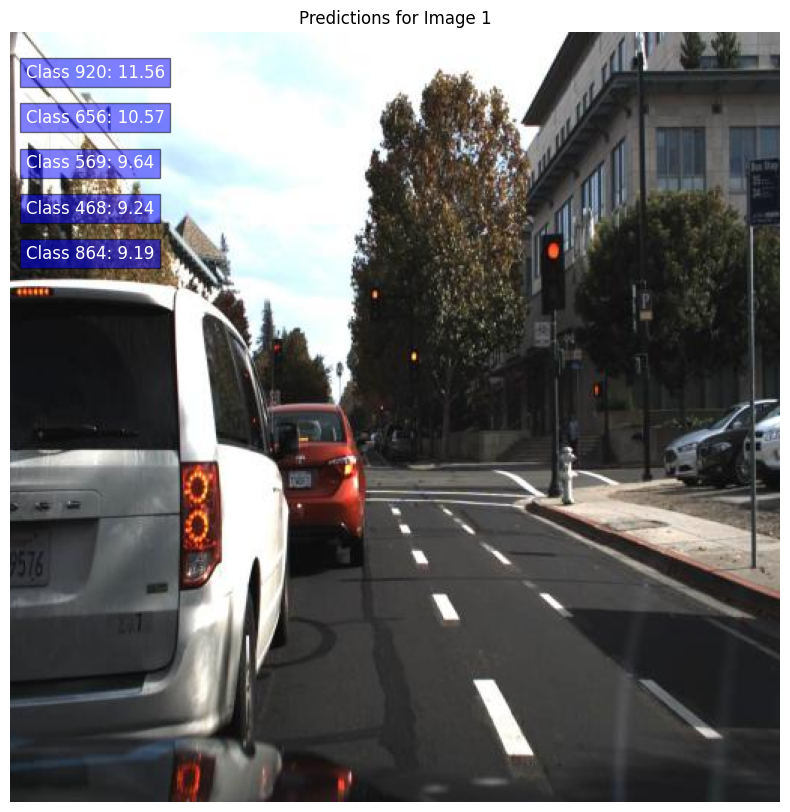

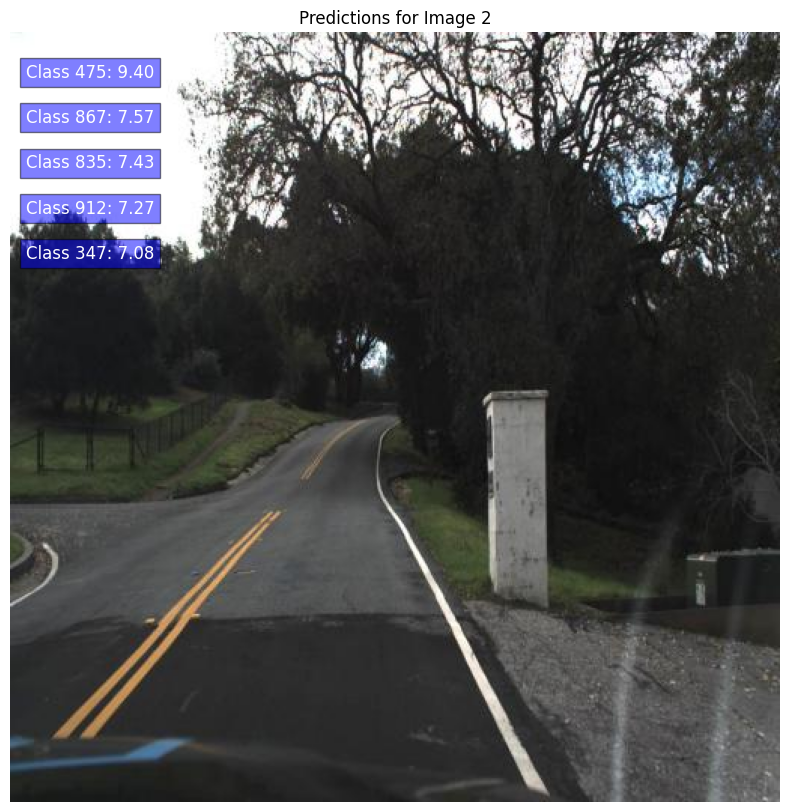

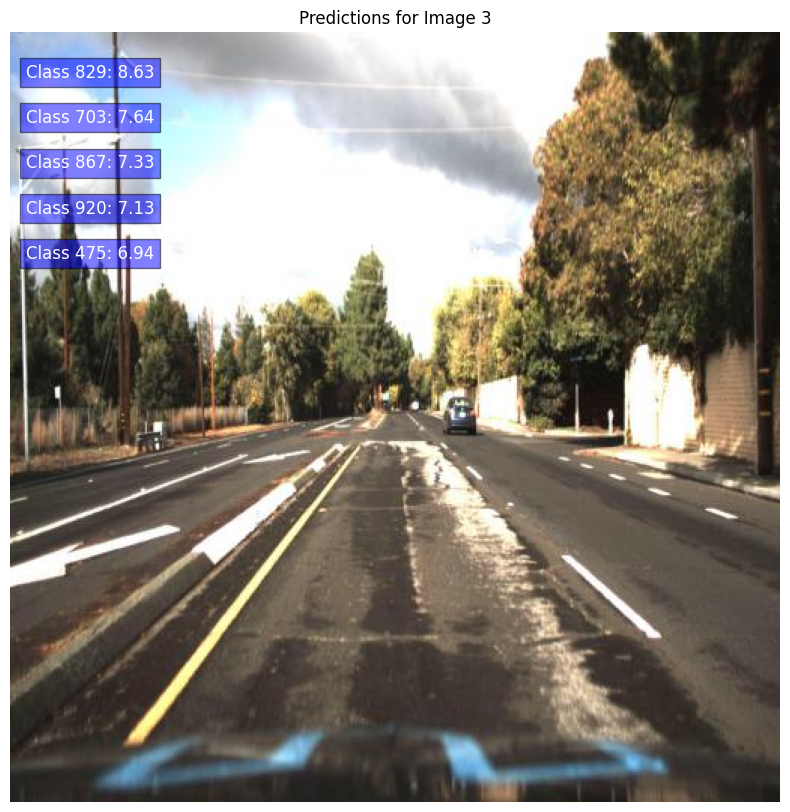

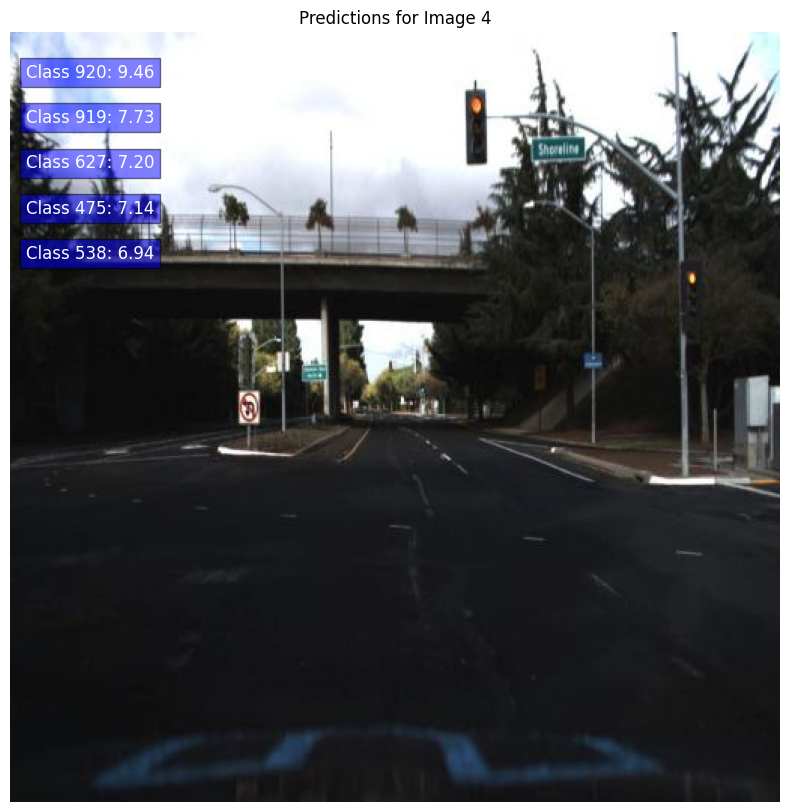

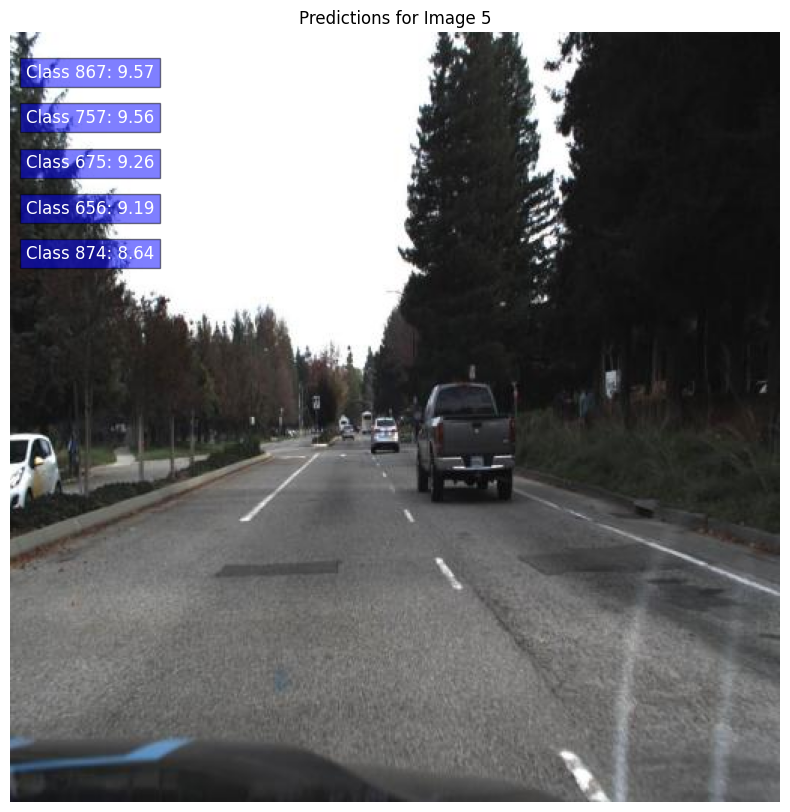

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Define paths to validation images
val_images_dir = "/kaggle/working/export/val/images"
val_images = [os.path.join(val_images_dir, img) for img in os.listdir(val_images_dir)[:5]]

# Define preprocessing pipeline for images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ImageNet
])

# Run predictions and visualize
for i, img_path in enumerate(val_images):
    # Open image
    img = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB image

    # Preprocess the image
    input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Ensure input tensor is on the same device as the model
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Run inference on the image
    results = model(input_tensor)  # YOLO model inference (assuming classification)

    # Convert predictions to numpy for easier handling
    results_np = results.cpu().detach().numpy()

    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')

    # If the model provides classification output, display labels
    if len(results_np.shape) == 2:  # Assuming output is (batch_size, num_classes)
        top_classes = results_np[0].argsort()[-5:][::-1]  # Top 5 predictions
        labels = [f"Class {cls}: {results_np[0][cls]:.2f}" for cls in top_classes]

        for j, label in enumerate(labels):
            plt.text(
                10, 30 + j * 30, label, fontsize=12, color='white',
                bbox=dict(facecolor='blue', alpha=0.5)
            )
    else:
        # If the model is an object detection model but does not return structured boxes
        print("Check model output structure for bounding boxes and classes.")

    plt.title(f"Predictions for Image {i + 1}")
    plt.show()


In [ ]:
import torch
from ultralytics import YOLO

# Load the YOLOv8 model
model_path = "/kaggle/working/yolov8n.pt"
model = YOLO(model_path)

# Print model summary
print(model.model)  # This will display the architecture of the YOLOv8 model.

# Calculate total trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.model.parameters() if not p.requires_grad)
total_params = trainable_params + non_trainable_params

print("\nModel Parameters:")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")
print(f"Total Parameters: {total_params:,}")


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

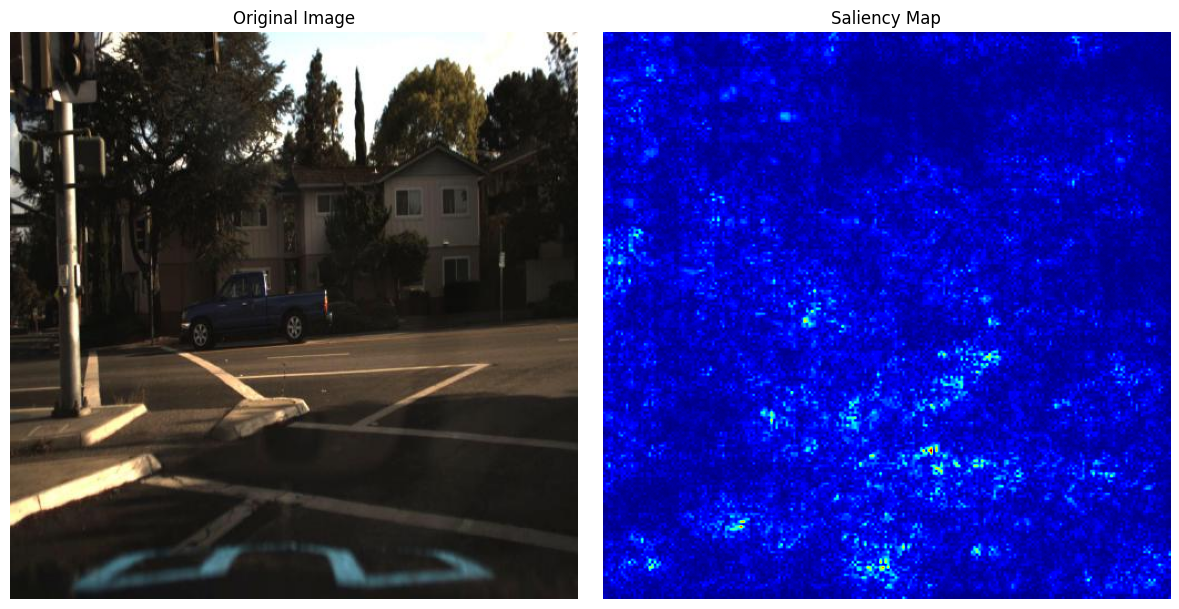

In [ ]:



def preprocess_image(image_path, image_size=224):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0), image


def generate_saliency_map(model, image_tensor, class_idx=None):
    model.eval()
    image_tensor.requires_grad_()

    output = model(image_tensor)


    if class_idx is None:
        class_idx = torch.argmax(output)


    model.zero_grad()
    output[0, class_idx].backward()


    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    return saliency[0].cpu().numpy()


def display_saliency_map(original_image, saliency_map):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='jet')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    model = (pretrained=True)
    model = YOLO(model_path)
    # Path to the input image
    image_path = "/kaggle/input/retinanet/Self Driving Car/export/1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg"  # Change this to your image path

    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path)

    # Generate the saliency map
    saliency_map = generate_saliency_map(model, image_tensor)

    # Display the results
    display_saliency_map(original_image, saliency_map)


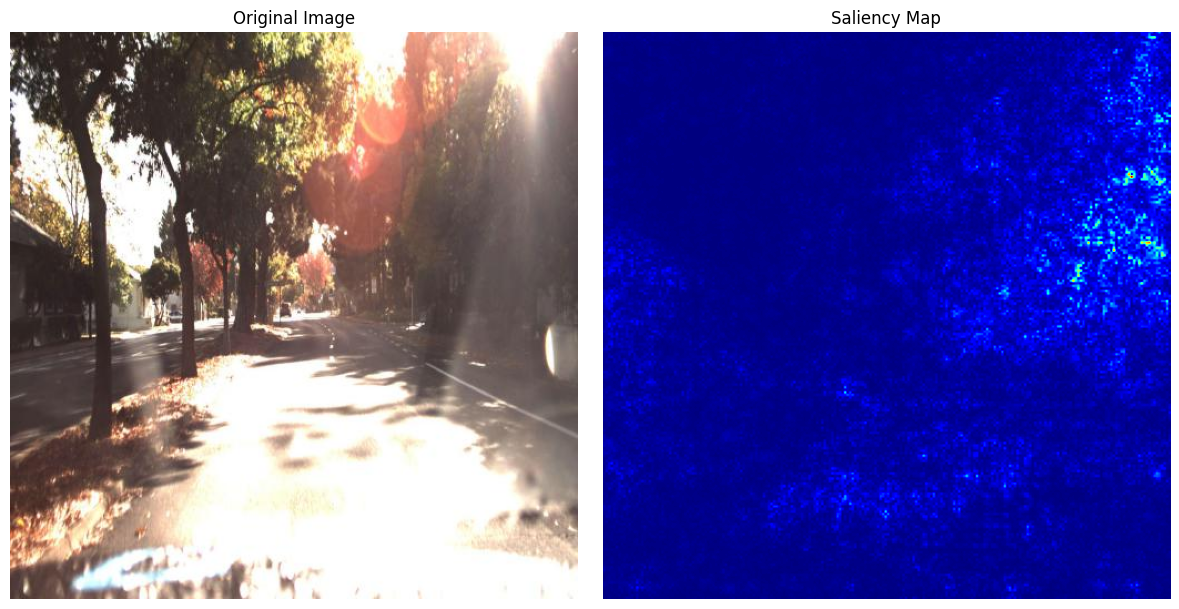

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.models import resnet50

# Function to preprocess the image
def preprocess_image(image_path, image_size=224):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0), image

# Saliency Map Function
def generate_saliency_map(model, image_tensor, class_idx=None):
    model.eval()
    image_tensor.requires_grad_()  # Enable gradient tracking on the input image

    output = model(image_tensor)  # Forward pass

    # If no class index is provided, use the class with the highest score
    if class_idx is None:
        class_idx = torch.argmax(output)

    # Zero gradients and compute gradients with respect to the chosen class
    model.zero_grad()
    output[0, class_idx].backward()

    # Compute the absolute value of gradients and get the max channel
    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    return saliency[0].cpu().numpy()

# Display the Saliency Map
def display_saliency_map(original_image, saliency_map):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='jet')
    plt.title("Saliency Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main Script
if __name__ == "__main__":
    # Load a pretrained model (ResNet50 as an example)
     model = (pretrained=True)
    model = YOLO(model_path)

    # Path to the input image
    image_path = "/kaggle/input/retinanet/Self Driving Car/export/1478020200690374841_jpg.rf.KmwLgD8EYMttyH8e6oJC.jpg"  # Change this to your image path

    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path)

    # Generate the saliency map
    saliency_map = generate_saliency_map(model, image_tensor)

    # Display the results
    display_saliency_map(original_image, saliency_map)
